# Основы машинного обучения (ИАД)
## НИУ ВШЭ, 2021-2022 учебный год

### Домашнее задание №8

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

# Бустинг

## Градиентный бустинг своими руками (3 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним **основные формулы**.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$.

> Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.


В качестве функции потерь возьмите **MSE**.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [2]:
a = np.array([[1,2],[1,2],[1,2]])
a.shape[0]

3

In [3]:
a[:,0]

array([1, 1, 1])

In [4]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [5]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1,flag = 'step_opt' ):
        """
        PARAMETERS:
        flag : 'step_opt' - флаг по умолчанию, с оптимазицией шагов
        'simple' - без оптимизации
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n = n_estimators
        self.md = max_depth
        self.lr = learning_rate
        self.gammas = []
        self.s = []
        self.forest = []
        self.flag = flag
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        # your code here
        y_new = np.zeros_like(y)
        if self.flag == 'simple':
            for _ in range(self.n):
                y_new += self.lr*self._fit_predict_tree(x, y - y_new)
                self.s.append(y - y_new)
        elif self.flag == 'step_opt':
            for i in range(self.n):
                s = self._fit_predict_tree(x, y - y_new)
                gamma = minimize(lambda gam: mean_squared_error(y-y_new,gam*s),0.5)
                self.gammas.append(*gamma.x)
                y_new +=self.lr*gamma.x*s
                self.s.append(y - y_new)
        else:
            RaiseValueError('flag has only two possible values: "step_opt" and "simple"')

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self.md)
        tree.fit(x,y)
        self.forest.append(tree)
        return tree.predict(x)
    
    
    def par(self):
        return {'learning_rate':self.lr,
            'n':self.n,
           'max_depth': self.md,
           'gammas':self.gammas,
           's':self.s}

        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = np.zeros_like(x[:,0])
        if self.flag == 'simple':
            for i in range(self.n):
                y_pred += self.forest[i].predict(x)*self.lr
        elif self.flag == 'step_opt':
            for i in range(self.n):
                y_pred += self.gammas[i]*self.forest[i].predict(x)*self.lr
        else:
            RaiseValueError('flag has only two possible values: "step_opt" and "simple"')
        return y_pred

Проверьте вашу реализацию на Boston dataset. 

> Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.



In [6]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

c:\users\крот\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the 

In [7]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [ ]:
from sklearn.model_selection import GridSearchCV

In [40]:
np.random.seed(19052019)
minimum = np.inf
for n in np.arange(1,111,10):
    for max_depth in np.arange(1,15,1):
        for learning_rate in np.arange(0.05,1,0.05):
            regressor = GradientBoosting(n,max_depth,learning_rate)
            regressor.fit(X_train,y_train)
            minim_1 = mean_squared_error(y_test,regressor.predict(X_test))
            if minim_1<minimum:
                minimum=minim_1
                par = regressor.par()
print('Parametrs:',par)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [09:14<00:00, 50.38s/it]


Parametrs: {'learning_rate': 0.6000000000000001, 'n': 91, 'max_depth': 9, 'gammas': [0.9999999999319055, 1.0000000016895387, 1.0000000016556965, 1.0000000018463946, 0.9999999926435766, 0.999999991004239, 0.999999993641906, 0.9999999932125282, 0.9999999967090873, 1.0000000274074865, 0.9999999839068098, 0.9999999932667449, 1.0000000570520824, 1.000000000313865, 0.9999999951059664, 0.9381933227011519, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 's': [array([ 6.18      , 15.48      ,  8.98285714,  8.88      ,  9.18742857,
        5.08      ,  1.74      ,  8.88742857,  9.45      ,  8.48742857,
        8.08285714,  6.65860465, 10.38      , 14.47      ,  9.55860465,


In [42]:
print('Mse=', minimum)

Mse= 9.26841098299222


In [44]:
np.random.seed(19052019)
minimum = np.inf
for n in np.arange(20,60,10):
    for max_depth in np.arange(2,16,2):
        for learning_rate in np.arange(0.1,1,0.1):
            regressor = GradientBoosting(n,max_depth,learning_rate,flag = 'simple')
            regressor.fit(X_train,y_train)
            minim_1 = mean_squared_error(y_test,regressor.predict(X_test))
            if minim_1<minimum:
                minimum=minim_1
                par = regressor.par()
print('Parametrs:',par,'Mse=',minimum)


Parametrs: {'learning_rate': 0.7000000000000001, 'n': 40, 'max_depth': 10, 'gammas': [], 's': [array([ 4.8       , 11.61      ,  6.9215    ,  6.785     ,  6.98147059,
        3.81      ,  1.5       ,  6.68147059,  7.11      ,  6.28147059,
        6.0215    ,  4.79655172,  7.59      , 10.83      ,  6.535     ,
        5.0215    ,  9.75      ,  5.73      ,  6.24692308,  5.0215    ,
        6.45      ,  5.62666667,  9.935     ,  9.3       ,  5.835     ,
        3.99      ,  1.39      ,  6.93666667,  8.25      ,  9.03      ,
        2.962     ,  6.035     ,  9.69655172,  5.13      ,  4.14      ,
        9.6       ,  6.69      ,  7.335     ,  5.05666667,  6.74692308,
        5.64      ,  6.6       ,  8.7       ,  6.48147059,  9.93      ,
        9.21      ,  7.79      ,  6.98147059, 11.28      ,  8.38147059,
        6.435     ,  4.08      ,  4.38      ,  5.67      ,  7.29655172,
        9.51      ,  5.925     ,  3.81      ,  5.38147059,  9.09      ,
        5.64      ,  2.49      ,  5.88147

In [45]:
print('Mse=', minimum)

Mse= 9.989574602172306


Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да / Нет

Да


## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {`XGboost`, `catboost`, `LightGBM`} и `GridSearchCV` для достижения результата.

> Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.



In [46]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering-data/flight_delays_test.csv')

In [47]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [49]:
# Референс
from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

0.704907376396969

In [50]:
np.sort(train['DayOfWeek'].unique())

array(['c-1', 'c-2', 'c-3', 'c-4', 'c-5', 'c-6', 'c-7'], dtype=object)

In [51]:
np.sort(train['DayofMonth'].unique())

array(['c-1', 'c-10', 'c-11', 'c-12', 'c-13', 'c-14', 'c-15', 'c-16',
       'c-17', 'c-18', 'c-19', 'c-2', 'c-20', 'c-21', 'c-22', 'c-23',
       'c-24', 'c-25', 'c-26', 'c-27', 'c-28', 'c-29', 'c-3', 'c-30',
       'c-31', 'c-4', 'c-5', 'c-6', 'c-7', 'c-8', 'c-9'], dtype=object)

In [52]:
np.sort(train['Origin'].unique())[:15]

array(['ABE', 'ABI', 'ABQ', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY', 'ADK',
       'ADQ', 'AEX', 'AGS', 'AKN', 'ALB', 'AMA'], dtype=object)

In [53]:
np.sort(train['Dest'].unique())[:15]

array(['ABE', 'ABI', 'ABQ', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY', 'ADQ',
       'AEX', 'AGS', 'AKN', 'ALB', 'AMA', 'ANC'], dtype=object)

Переработаем признаки, чтобы они были разными

In [54]:
train["DayOfWeek"] = train["DayOfWeek"].map(lambda x: "Week" + x)
train["DayofMonth"] = train["DayofMonth"].map(lambda x: "Month" + x)
train["Origin"] = train["Origin"].map(lambda x: "Origin" + x)
train["Dest"] = train["Dest"].map(lambda x: "Dest" + x)

In [55]:
y_train = train["dep_delayed_15min"].map({"Y": 1, "N": 0}).values
features = ["Month", "DayofMonth","DayOfWeek", "DepTime", "UniqueCarrier","Origin","Dest"]
train  = pd.get_dummies(train[features])
X_train = train.values

In [78]:
x_tr, x_v, y_tr, y_v =  train_test_split(X_train, y_train, test_size=0.2)

In [74]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [81]:
cl1 = LGBMClassifier()
cl1.fit(x_tr,y_tr)
roc_auc_score(y_v, cl1.predict_proba(x_v)[:,1])

0.7405009099351997

In [83]:
cl1 = CatBoostClassifier(silent=True)
cl1.fit(x_tr,y_tr)
roc_auc_score(y_v, cl1.predict_proba(x_v)[:,1])

0.7488262300518327

# Кластеризация

## DBSCAN своими руками (3 + 2* баллов)


```
DBSCAN: Density-based spatial clustering of applications with noise
```


Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [ ]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [ ]:
# Рекомендации -- это только рекомендации
class dbscan:
    def __init__(self, eps, min_samples):
        # your code here

        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        # your code here

        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        # your code here

        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # your code here

        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # your code here

        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        # your code here



    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # your code here


    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        # your code here

    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        # your code here
        

Проверим себя на простом примере:

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

In [ ]:
# your code here


Референс:

In [ ]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()


> Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):



In [ ]:
# your code here


Или хотя бы что-нибудь такое: 

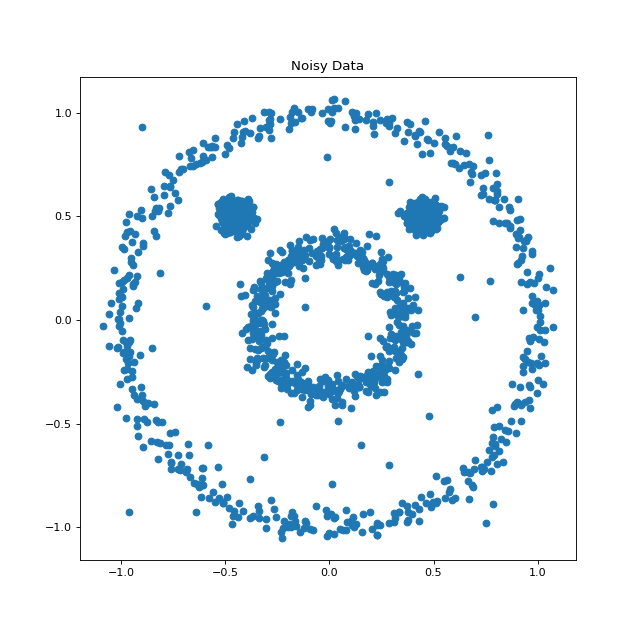

In [ ]:
# your code here



> Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:



In [ ]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

In [ ]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

## Применяем DBSCAN (3 балла)

__[1.5 балла]__ Возьмите колонки `Distance` и `DepTime` (из датасета о задержках самолётов). Запустите на тренировочной выборке на них DBSCAN. Нарисуйте облоко рассеивания с получившимися кластерами. Насколько много их вышло? 

In [ ]:
# your code here  ლ(ಠ益ಠლ)


Попробуйте перебрать параметры `eps` и `min_samples` по решётке и нарисовать для каждой пары облако рассеивания. При каких параметрах шумовых точек оказывается больше всего? Почему так происходит? 

__Ответ:__ 

In [ ]:
# your code here   ⟅⎛ꌩωꌩ⎞⟆


__[1.5 балла]__ Добавьте в датасет новую категориальную переменную: номер кластера из DBSCAN и обучите Catboost со своими лучшими гиперпараметрами. Улучшилось ли качество модели на тестовой выборке? Как думаете, почему? 

In [ ]:
# your code here  ¯\_(ツ)_/¯


__Ответ:__

# Небольшие подарочки

**+0.1 балла** за фотографию того, как вы проводите лето на открытом воздухе

**+0.1 балла** за смешной мем по машинному обучению

**+0.1 балла** за развернутый отзыв о курсе: ваших впечатлениях, сложностях и радостях, любимых темах и т.д.